In [1]:
from sklearn.cluster import KMeans
import numpy as np
import nsepy
import datetime
import ta
import pandas as pd
from pandas_datareader import data
import random

In [2]:
X=pd.read_csv('bob.csv')
X

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-02,134.020004,130.669998,134.020004,133.639999,621765.0,82.026894
1,2012-01-03,140.979996,134.389999,134.389999,140.050003,1308700.0,85.961281
2,2012-01-04,142.000000,138.259995,140.979996,140.210007,1515265.0,86.059494
3,2012-01-05,141.570007,137.729996,140.399994,138.919998,2718015.0,85.267693
4,2012-01-06,141.000000,136.639999,137.000000,140.449997,923805.0,86.206802
...,...,...,...,...,...,...,...
1881,2019-08-26,99.900002,91.500000,99.900002,95.050003,43374486.0,95.050003
1882,2019-08-27,99.199997,96.650002,97.000000,97.300003,35349172.0,97.300003
1883,2019-08-28,97.650002,93.750000,97.199997,94.500000,24947200.0,94.500000
1884,2019-08-29,96.000000,91.349998,94.000000,91.800003,28470571.0,91.800003


In [5]:
def data1():
    X=pd.read_csv('bob.csv')
    X['c-o']=(X.Close-X.Open)/X.Open*100
    X['candle']=np.where(X['c-o'].values<-2,0,np.where(X['c-o'].values<-1,1,np.where(X['c-o'].values<0,2,np.where(X['c-o'].values<1,3,np.where(X['c-o'].values<2,4,5))))) #This line updates the value of candle column based on the value of corresponding c-o. If c-o <2 it is 4 else it is 5. if c-o<1 it is 3 else it goes to previous condition and so on.
    X = X.dropna(axis = 0, how ='any') #drop rows with missing values meaning if row has 'any ' empty values drop it
    X = X.reset_index()
    X = X.reset_index()
    X['cash']=0
    X['action']=""
    X['action1']=""
    return X

In [6]:
X=data1()
X

,level_0,index,Date,High,Low,Open,Close,Volume,Adj Close,c-o,candle,cash,action,action1
0,0,0,2012-01-02,134.020004,130.669998,134.020004,133.639999,621765.0,82.026894,-0.283543,2,0,,
1,1,1,2012-01-03,140.979996,134.389999,134.389999,140.050003,1308700.0,85.961281,4.211626,5,0,,
2,2,2,2012-01-04,142.000000,138.259995,140.979996,140.210007,1515265.0,86.059494,-0.546169,2,0,,
3,3,3,2012-01-05,141.570007,137.729996,140.399994,138.919998,2718015.0,85.267693,-1.054128,1,0,,
4,4,4,2012-01-06,141.000000,136.639999,137.000000,140.449997,923805.0,86.206802,2.518246,5,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,1881,1881,2019-08-26,99.900002,91.500000,99.900002,95.050003,43374486.0,95.050003,-4.854853,0,0,,
1882,1882,1882,2019-08-27,99.199997,96.650002,97.000000,97.300003,35349172.0,97.300003,0.309281,3,0,,
1883,1883,1883,2019-08-28,97.650002,93.750000,97.199997,94.500000,24947200.0,94.500000,-2.777775,0,0,,
1884,1884,1884,2019-08-29,96.000000,91.349998,94.000000,91.800003,28470571.0,91.800003,-2.340422,0,0,,


Populating the interactive namespace from numpy and matplotlib


c:\python\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


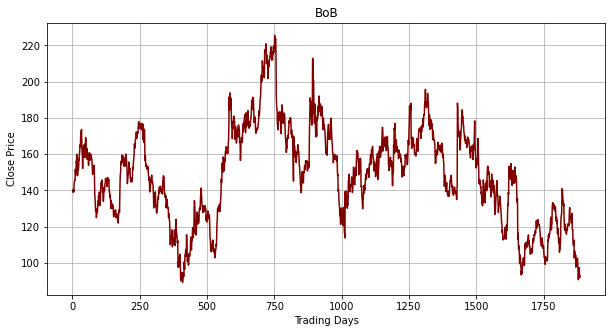

In [7]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('pylab', 'inline')
fig = plt.figure()
ax=X.loc[1:4577,'Close'].plot(grid="True",figsize=(10,5), title='BoB',color="maroon")
ax.set_xlabel("Trading Days")
ax.set_ylabel("Close Price")
plt.savefig("IMAGES/BoB.png")
plt.show()

In [8]:
def getState(t):    
    return(X['candle'][t]) 

In [9]:
class Agent:
    def __init__(self):
        self.epsilon = 1.0 #Value of  epsilon to denote we are exploring as much as possible
        self.gamma = 0.618 #Discount factor decided as 0.618
        self.epsilon_decay = 0.995 #rate at which epsilon decays as we reach optimal solution.
        self.epsilon_min = 0.01 #minimum value epsilon should take
        self.Q = np.matrix(np.zeros([6,3])) #6 states and 3 actions for each state initial Q table entries are zero.
        self.learning_rate=0.03 #parameter used in Q-learning equation.
        
    def getAction(self,state):
        a=[1,0,2]
        if np.random.rand() <= self.epsilon: #compares random numbers between -1 to 1 to epsilon value at that point of time.
            return random.choice(a) #if true, choose a random value of a.
        return np.argmax(self.Q[state,])  #else, choose the action with highest state value 1-epsilon times(acc to epsilon greedy algo)
    
    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    def update(self,state,action,reward,next_state,next_action):
            self.Q[state,action]= self.Q[state,action] + self.learning_rate * (reward + self.gamma * np.max(self.Q[next_state, :])
                                                                - self.Q[state,action])


In [10]:
episode_count=200
agent=Agent()
agent.Q
m1=0
m2=0
for e in range(1,episode_count+1):
    X=data1()  #updated data entry   
    data_length_start=1
    data_length=1419
    agent.epsilon=1
    state = getState(data_length_start) #get state X['candle'][1] always here meaning initial state is always 3 initially.
    action = agent.getAction(state) #based on that state, we select action of state 3 having max.reward 1-epsilon times and random action e times.
    last_action=None #for first state of the episode last action NULL.
    last_price=0
    last_quantity=0
    capital=X.loc[data_length_start,'Open']*100 #Initial capital at start of episode. based on the entry at 1st  row.
    margin=X.loc[data_length_start,'Open']*100  #initial margin
    brok_rate=0.0010 
    profit=0    #no profit at start of episode.
    print("Episod {}/{}".format(e,episode_count))
    count=0
    for t in range(data_length_start,data_length-1): #from 1 to 4577 possible states in each episode.
        #print('t',t)        
        reward=0 #reward for each action taken =0.
        if last_action=='sold': #if last action taken (in previous time step) is 'sold'
            tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate  #brokerage charges 
            tprofit=(last_price-X.loc[t,'Close'])*last_quantity #profit made by selling the quantities at the new time step -remember the last action is taken on this time step.
            tprofit1=(tprofit/(last_price*last_quantity))*100 #calculating the profit % based on price at whic stock was bought.
             
            if tprofit1<-10: #if loss is too high i.e less tha  10%
                profit=profit+tprofit #always this is the new profit updating for each episode - we only see profit/loss when we sell
                margin=margin+(last_quantity*last_price)+(tprofit) #updating the margin
                X.loc[t,'cash']=margin      #denotes the min.amount investor must pay for security.
                #print('close short stop loss @',X['Open'].iloc[t])
                last_action=None # change the last action
                X.loc[t,'action']="close short" #close the shorting position
                X.loc[t,'action1']="long" #start your long position on the stock.
                reward= max((np.log(last_price)-np.log(X.loc[t,'Open'])),0) #updating the reward as a logarithmic difference b/w buying price and selling price if loss is made else 0 for profit- reward for closing a short position. 0 reward for taking such an action since it was suboptimal.
        elif last_action=='bought':#if your action was to buy the stock
            tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate #update broker fee always fixed.
            tprofit=(X.loc[t,'Close']-last_price)*last_quantity #profit 
            tprofit1=(tprofit/(last_price*last_quantity))*100
            if tprofit1<-10: #incase you had bought the stock and now currently losses is more than 10% we will close our long positionon the stock and bet the stock goes down.
                profit=profit+tprofit
                margin=margin+(last_quantity*last_price)+(tprofit)
                X.loc[t,'cash']=margin        
                #print('close long stop loss @',X.loc[t,'Open'])
                last_action=None
                X.loc[t,'action']="close long"
                X.loc[t,'action1']="short"
                reward= max((np.log(X.loc[t,'Open'])-np.log(last_price+tbrokerage)),0)      #reward will be 0 in this case for taking sub-optimal action.            
                          
            
        if action == 1  and last_action==None : #generally the first encountered loop here -for the first state in the episode. action==1 means long position - algo is by default optimistic price will go up.
            #print('in long')
            X.loc[t,'cash']=margin      #update the value of that entry of X['cash'] to margin.     MARGIN= HOW MUCH CASH YOU HAVE TO SPEND. 
            last_quantity=margin//X.loc[t,'Close']  #number of stocks owned based on the money you had / closing price of stock for that particular time step- the quotient basically.
            margin=margin%X.loc[t,'Close'] #remaining cash after having bought the last_quantity number of stocks. 
            last_price=X.loc[t,'Close'] #price of last stock bought updated.
            last_action='bought'#to denote we have bought a stock.
            #print('open long @',last_price)
            X.loc[t,'action']="open long" #A long—or a long position—refers to the purchase of an asset with the expectation it will increase in value—a bullish attitude.We are betting the stock price will increase-this action of betting bullishly is open long
            X.loc[t,'action1']="long" #Betting bullishly.
            count=count+1 #Count of buys?
        elif action == 1  and last_action=='sold':
            #print('in close short')
            tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate #Whenever your last action was buy or sell -we have to pay brokerage fee.
            tprofit=(last_price-X.loc[t,'Close']-tbrokerage)*last_quantity #profit made or loss .
            tprofit1=(tprofit/(last_price*last_quantity))*100 #percent of profit.
            if  tprofit>10 or tprofit1<-5: #if profit was more than 3% or loss was also more than 3%
                profit=profit+tprofit #profit update
                margin=margin+(last_quantity*last_price)+(tprofit) #Cash in hand
                X.loc[t,'cash']=margin      #update cash in hand as margin -negative if we were in loss.
                #print('close short @',X.loc[t,'Open'])
                last_action=None # we wont take any action.
                X.loc[t,'action']="close short" #in this scenario we always go long if we were shorting -bettng stock goes up.
                X.loc[t,'action1']="long" #new position.
                reward= max((np.log(last_price)-np.log(X.loc[t,'Close']+tbrokerage)),0) #0 for loss positive valeu for profit.
            else:
                tp=(last_price-X.loc[t,'Close'])*last_quantity
                original=margin+(last_quantity*last_price)
                X.loc[t,'cash']=original+tp   #Else while updating the cash in hand we wont change our position-if we were shorting we continue shorting.
                
        elif action == 1  and last_action=='bought':
            #print('in hold long')
            X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close']) #updating cash in hand to buy/sell stock.
        elif action == 2  and last_action==None and margin>X.loc[t,'Close']:#Say this is the first time step and your margin> closing price -Meaning the value of stock has gone down after that day of trading- so we short it-bet it will fall more.
            #print('in short')
            X.loc[t,'cash']=margin #your updated margin - cash in hand.        
            last_quantity=margin//X.loc[t,'Close']# you bought these number of stocks.
            margin=margin%X.loc[t,'Close']#remaining cash.
            last_price=X.loc[t,'Close']#price of last bought stock.
            last_action='sold'        #last action taken is 'sold'
            #print('open short @',last_price)
            X.loc[t,'action']="open short" #we wll bet that stock goes down. we are shorting our position and we get profit if stock goes down.
            X.loc[t,'action1']="short"   #this action is a subset of shorting pisition taken by agent.   
            count=count+1 #update the count of no. of time steps we bought the stock. Only difference here is we shorted the stock.
        elif action == 2 and  last_action=='bought':#close long ->previous time step we bought the stock and action==2 represents we are shorting. So if last action was to buy the stock(long ) we have to close our long position.
            #print('in close long')
            tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate #this denotes the brokerage fee to be paid for having bought the stock previously 
            tprofit=(X.loc[t,'Close']-last_price-tbrokerage)*last_quantity #Denotes the profit made after brokerage fee has been deducted.
            tprofit1=(tprofit/(last_price*last_quantity))*100 #% profit made (% of previous time step margin)
            if tprofit1>10 or tprofit1<-5: #if a profit of 3% or more was made or a  loss of 3% or less was made
                profit=profit+tprofit # update the profit from the episode.
                margin=margin+(last_quantity*last_price)+(tprofit) #update the margin meaning new money in hand or money in debt.
                X.loc[t,'cash']=margin        #update the cash in hand at time step to be margin.
                #print('close long @',X.loc[t,'Open'])
                last_action=None
                X.loc[t,'action']="close long" #close long position and we start to short.
                X.loc[t,'action1']="short"# action comes under the shorting position.
                reward= max((np.log(X.loc[t,'Close'])-np.log(last_price+tbrokerage)),0) #denote choosing reward as 0 or the logarithmic difference between close price at which you sold -log(last_price +broker fee) based on which is higher(in loss means reward=0))
            else:
                X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close']) #update the cash at that time step to be margin + cash in hand after selling the last_qauntity stocks.
                
            
        elif action == 2  and last_action=='sold': #in a shorting position and you have also taken last action to be sold.
            #print('in hold short')
            tp=(last_price-X.loc[t,'Close'])*last_quantity # amount of profit lossed or loss made.
            original=margin+(last_quantity*last_price) # margin of cash in hand.
            X.loc[t,'cash']=original+tp #this is the net cash in hand taking into consideration the profits missed or losses saved.
        else:            
            if last_action==None: 
                X.loc[t,'cash']=margin #cash in hand is margin itself 
                #print('in hold1')
            elif last_action=='bought':
                X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close'])  #
                #print('in hold2')
            elif last_action=='sold':
                tp=(last_price-X.loc[t,'Close'])*last_quantity
                original=margin+(last_quantity*last_price)
                X.loc[t,'cash']=original+tp     
                #print('in hold3')
                                       
              
        next_state=getState(t+1)
        next_action=agent.getAction(next_state)
        agent.update(state,action,reward,next_state,next_action)
        state=next_state
        action=next_action
        
        if t==data_length-2:
                print("--------------------------------")
                if  last_action=='sold':
                    tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate
                    tprofit=(last_price-X.loc[t,'Close']-tbrokerage)*last_quantity
                    profit=profit+tprofit
                    margin=margin+(last_quantity*last_price)+(tprofit) 
                    X.loc[t,'cash']=margin
                    #print('close short @',X.loc[t,'Close'])
                    last_action=None
                    X.loc[t,'action']="close short"
                    X.loc[t,'action1']="long"
                elif last_action=='bought':
                    tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate
                    tprofit=(X.loc[t,'Close']-last_price-tbrokerage)*last_quantity
                    profit=profit+tprofit
                    margin=margin+(last_quantity*last_price)+(tprofit) 
                    X.loc[t,'cash']=margin
                    #print('close long @',X.loc[t,'Close'])
                    last_action=None
                    X.loc[t,'action']="close long"
                    X.loc[t,'action1']="short"
                print("\n***********************")
                print("Profit is ",profit)
                print("Initial Capital is ",capital)    
                print("Current Capital is ",margin)
                roi=((margin-capital)/capital)*100
                print("%ROI is ",roi)
                bnh=((X.loc[t,'Close']-X.loc[data_length_start,'Close'])/X.loc[data_length_start,'Close'])*100
                print("% Buy and Hold=",bnh)
                print("count",count)
                print("qtable",agent.Q)
                print("epsilon",agent.epsilon)
                print("--------------------------------")
                       
        if (agent.epsilon > agent.epsilon_min) and e>1:
                       agent.epsilon *= agent.epsilon_decay
                       
    
    m3=roi
    if m3>m2:
        m1=e
        m2=m3
    #To save model            
    np.save('C:\Python\RL PROJECT CODE\BoB-RESULTS\BoB-TRAINING\Qtable/Qtable'+ str(e)+str('.npy'), agent.Q)
    np.save('C:\Python\RL PROJECT CODE\BoB-RESULTS\BoB-TRAINING\Epsilon/epsilon'+ str(e)+str('.npy'), agent.epsilon)
    np.save('C:\Python\RL PROJECT CODE\BoB-RESULTS\BoB-TRAINING\Gamma/gamma'+ str(e)+str('.npy'), agent.gamma)
    np.save('C:\Python\RL PROJECT CODE\BoB-RESULTS\BoB-TRAINING\Learning_Rate/learning_rate'+ str(e)+str('.npy'), agent.learning_rate)
    X.to_csv('C:\Python\RL PROJECT CODE\BoB-RESULTS\BoB-TRAINING\AfterTrain/AfterTrain'+str(e)+str('.csv'))
print("e={},roi={}".format(m1,m2))

Episod 1/200
--------------------------------

***********************
Profit is  -10407.947285362245
Initial Capital is  13438.999938964844
Current Capital is  3031.0526536025995
%ROI is  -77.44584665995563
% Buy and Hold= -0.32131163044377464
count 104
qtable [[0.00409012 0.00821772 0.00703053]
 [0.00388195 0.00418659 0.00374384]
 [0.00415103 0.0052695  0.00819014]
 [0.00334166 0.00668263 0.00874608]
 [0.0033897  0.00629327 0.00942271]
 [0.00307347 0.0037111  0.01366837]]
epsilon 1
--------------------------------
Episod 2/200
--------------------------------

***********************
Profit is  3001.891416160595
Initial Capital is  13438.999938964844
Current Capital is  16440.891355125426
%ROI is  22.33716370112438
% Buy and Hold= -0.32131163044377464
count 136
qtable [[0.00491347 0.01044357 0.00660754]
 [0.00425289 0.00636875 0.00434797]
 [0.00465167 0.00527728 0.00517872]
 [0.00422924 0.00524013 0.00527524]
 [0.00401397 0.00616123 0.00778684]
 [0.00359995 0.00416825 0.01510145]]
ep

--------------------------------

***********************
Profit is  4209.331648948664
Initial Capital is  13438.999938964844
Current Capital is  17648.331587913526
%ROI is  31.321762542346672
% Buy and Hold= -0.32131163044377464
count 126
qtable [[0.0054614  0.00977583 0.00486943]
 [0.00464661 0.00455407 0.00559284]
 [0.00459147 0.00575735 0.00450898]
 [0.00461673 0.00477985 0.00649388]
 [0.00488448 0.00431863 0.004259  ]
 [0.00411849 0.00420375 0.0173776 ]]
epsilon 0.00998645168764533
--------------------------------
Episod 18/200
--------------------------------

***********************
Profit is  26340.650003791805
Initial Capital is  13438.999938964844
Current Capital is  39779.64994275671
%ROI is  196.00156353465087
% Buy and Hold= -0.32131163044377464
count 119
qtable [[0.00549664 0.00873177 0.00539112]
 [0.00490492 0.00615475 0.00608476]
 [0.00511379 0.00555816 0.00544423]
 [0.00471968 0.00524288 0.00737815]
 [0.00503092 0.00463405 0.00449607]
 [0.00462775 0.00426413 0.01655751

--------------------------------

***********************
Profit is  6254.897720329285
Initial Capital is  13438.999938964844
Current Capital is  19693.89765929412
%ROI is  46.542880785302465
% Buy and Hold= -0.32131163044377464
count 106
qtable [[0.0051098  0.00802881 0.00540608]
 [0.0046983  0.0049468  0.00486457]
 [0.00456133 0.00453766 0.00499336]
 [0.00454371 0.00418156 0.0072285 ]
 [0.00480706 0.0045364  0.00456014]
 [0.00399105 0.00564185 0.01579681]]
epsilon 0.00998645168764533
--------------------------------
Episod 34/200
--------------------------------

***********************
Profit is  -327.9216188659676
Initial Capital is  13438.999938964844
Current Capital is  13111.078320098863
%ROI is  -2.440074561762664
% Buy and Hold= -0.32131163044377464
count 113
qtable [[0.00575869 0.00664065 0.00543915]
 [0.00489853 0.00516296 0.00467118]
 [0.00469496 0.00463673 0.00463   ]
 [0.00460979 0.00461366 0.00463455]
 [0.00444096 0.00444438 0.00679756]
 [0.00436737 0.00545084 0.01380469

--------------------------------

***********************
Profit is  22309.444192901574
Initial Capital is  13438.999938964844
Current Capital is  35748.444131866425
%ROI is  166.00524067432949
% Buy and Hold= -0.32131163044377464
count 107
qtable [[0.00598971 0.01152396 0.00609277]
 [0.00488624 0.00514513 0.00605833]
 [0.00481387 0.00556338 0.00503564]
 [0.0042759  0.00504557 0.00684591]
 [0.00445667 0.00520143 0.00447392]
 [0.0046829  0.00459934 0.01801282]]
epsilon 0.00998645168764533
--------------------------------
Episod 50/200
--------------------------------

***********************
Profit is  -4173.406796104438
Initial Capital is  13438.999938964844
Current Capital is  9265.59314286042
%ROI is  -31.054444639173695
% Buy and Hold= -0.32131163044377464
count 117
qtable [[0.00568707 0.01147111 0.00626238]
 [0.00500541 0.00547772 0.00545363]
 [0.00520377 0.00455405 0.00456131]
 [0.00473261 0.00484428 0.00794061]
 [0.00452283 0.00490034 0.00525426]
 [0.0047194  0.0050926  0.0173016

--------------------------------

***********************
Profit is  1145.1210414047082
Initial Capital is  13438.999938964844
Current Capital is  14584.120980369546
%ROI is  8.520879876519341
% Buy and Hold= -0.32131163044377464
count 115
qtable [[0.00503792 0.00665941 0.00563832]
 [0.00460204 0.00559799 0.0049541 ]
 [0.00430336 0.00425041 0.00425691]
 [0.00478246 0.00522195 0.00519027]
 [0.00436133 0.00422546 0.00416844]
 [0.00469525 0.00414161 0.01384   ]]
epsilon 0.00998645168764533
--------------------------------
Episod 66/200
--------------------------------

***********************
Profit is  12630.623173675525
Initial Capital is  13438.999938964844
Current Capital is  26069.62311264037
%ROI is  93.9848443413894
% Buy and Hold= -0.32131163044377464
count 97
qtable [[0.00532057 0.00741613 0.00552707]
 [0.00465424 0.00446756 0.00663038]
 [0.00428943 0.00502617 0.0040984 ]
 [0.00427187 0.00499766 0.00427019]
 [0.00418006 0.00501439 0.00391553]
 [0.00477619 0.00442517 0.02250965]]


--------------------------------

***********************
Profit is  50600.80693126675
Initial Capital is  13438.999938964844
Current Capital is  64039.80687023159
%ROI is  376.52211593926336
% Buy and Hold= -0.32131163044377464
count 109
qtable [[0.00493912 0.01199236 0.00510774]
 [0.00497617 0.00456997 0.00704456]
 [0.00464434 0.00540491 0.00625965]
 [0.00481681 0.00554476 0.00456417]
 [0.00458889 0.00565484 0.00489401]
 [0.00407331 0.00594967 0.02250591]]
epsilon 0.00998645168764533
--------------------------------
Episod 82/200
--------------------------------

***********************
Profit is  5479.022993545506
Initial Capital is  13438.999938964844
Current Capital is  18918.022932510346
%ROI is  40.76957376612304
% Buy and Hold= -0.32131163044377464
count 108
qtable [[0.00506565 0.01088294 0.00591265]
 [0.00524738 0.00540017 0.00581427]
 [0.00455404 0.00530652 0.00598699]
 [0.00479896 0.00490142 0.00503483]
 [0.00524224 0.00495412 0.00481426]
 [0.00437075 0.00560881 0.01989596]]

--------------------------------

***********************
Profit is  -4472.79161593628
Initial Capital is  13438.999938964844
Current Capital is  8966.208323028572
%ROI is  -33.282176026862864
% Buy and Hold= -0.32131163044377464
count 116
qtable [[0.00546552 0.00683504 0.00498251]
 [0.00557563 0.00643503 0.00508511]
 [0.00427091 0.00424282 0.00473121]
 [0.00425435 0.00444364 0.00682174]
 [0.00423896 0.00497179 0.00469065]
 [0.00434381 0.004643   0.0178715 ]]
epsilon 0.00998645168764533
--------------------------------
Episod 98/200
--------------------------------

***********************
Profit is  103.64391230012507
Initial Capital is  13438.999938964844
Current Capital is  13542.643851264967
%ROI is  0.7712174475097662
% Buy and Hold= -0.32131163044377464
count 120
qtable [[0.0051846  0.00870016 0.00536505]
 [0.00523413 0.00644233 0.00512663]
 [0.00438159 0.0043664  0.00503054]
 [0.00439514 0.00445215 0.00781465]
 [0.00433771 0.00475805 0.00517013]
 [0.0043283  0.00442422 0.0168356

--------------------------------

***********************
Profit is  -4116.965211967468
Initial Capital is  13438.999938964844
Current Capital is  9322.034726997379
%ROI is  -30.634461125569285
% Buy and Hold= -0.32131163044377464
count 112
qtable [[0.00491789 0.00576669 0.00543646]
 [0.00445789 0.00571276 0.00490223]
 [0.00412659 0.00449242 0.00418206]
 [0.00432955 0.00479228 0.00614663]
 [0.00448099 0.00399092 0.0041344 ]
 [0.00423976 0.0055973  0.01854769]]
epsilon 0.00998645168764533
--------------------------------
Episod 114/200
--------------------------------

***********************
Profit is  -273.9383877258098
Initial Capital is  13438.999938964844
Current Capital is  13165.061551239036
%ROI is  -2.038383726244055
% Buy and Hold= -0.32131163044377464
count 115
qtable [[0.00492552 0.00701274 0.00513751]
 [0.00435566 0.00550625 0.00514012]
 [0.00440908 0.00468939 0.0044546 ]
 [0.00452814 0.00466053 0.00464472]
 [0.00458761 0.00400778 0.00982332]
 [0.00425876 0.00550398 0.01562

--------------------------------

***********************
Profit is  19829.723833793614
Initial Capital is  13438.999938964844
Current Capital is  33268.72377275846
%ROI is  147.55356740719668
% Buy and Hold= -0.32131163044377464
count 123
qtable [[0.00532718 0.01329347 0.00542229]
 [0.00575861 0.00541276 0.00532246]
 [0.00446543 0.00470438 0.00548669]
 [0.00441755 0.00510907 0.0042194 ]
 [0.00435939 0.0050411  0.00695294]
 [0.00427977 0.00570803 0.01773269]]
epsilon 0.00998645168764533
--------------------------------
Episod 130/200
--------------------------------

***********************
Profit is  -9982.115937736507
Initial Capital is  13438.999938964844
Current Capital is  3456.884001228339
%ROI is  -74.27722288170044
% Buy and Hold= -0.32131163044377464
count 112
qtable [[0.00539817 0.00714062 0.00558348]
 [0.00506983 0.00525014 0.00744389]
 [0.00465381 0.00445275 0.0044023 ]
 [0.00456483 0.00477782 0.00478799]
 [0.00441489 0.00481501 0.0048353 ]
 [0.00471979 0.00543844 0.0159923

--------------------------------

***********************
Profit is  14597.156079734834
Initial Capital is  13438.999938964844
Current Capital is  28036.156018699665
%ROI is  108.61787444028508
% Buy and Hold= -0.32131163044377464
count 114
qtable [[0.00577036 0.00820545 0.00597834]
 [0.0048967  0.00623901 0.00475746]
 [0.00524186 0.00496248 0.0049139 ]
 [0.00542148 0.00580568 0.00686832]
 [0.00485988 0.00435979 0.00524389]
 [0.00503709 0.0065033  0.0189661 ]]
epsilon 0.00998645168764533
--------------------------------
Episod 146/200
--------------------------------

***********************
Profit is  4280.753404273978
Initial Capital is  13438.999938964844
Current Capital is  17719.75334323883
%ROI is  31.85321395725608
% Buy and Hold= -0.32131163044377464
count 91
qtable [[0.00553749 0.00952684 0.0055462 ]
 [0.00512309 0.00466927 0.00458893]
 [0.00455039 0.00483045 0.00454571]
 [0.0046244  0.00456477 0.00453356]
 [0.00454654 0.0042571  0.00613225]
 [0.00495658 0.00625625 0.0185647 ]

--------------------------------

***********************
Profit is  -381.5162059097213
Initial Capital is  13438.999938964844
Current Capital is  13057.483733055124
%ROI is  -2.8388734849500037
% Buy and Hold= -0.32131163044377464
count 108
qtable [[0.00538739 0.00723464 0.00547445]
 [0.00466762 0.00557248 0.00468205]
 [0.00435531 0.00468647 0.00430846]
 [0.00420733 0.0040157  0.00638004]
 [0.00446601 0.00436806 0.0047459 ]
 [0.00469453 0.00503111 0.01739995]]
epsilon 0.00998645168764533
--------------------------------
Episod 162/200
--------------------------------

***********************
Profit is  -64.24374269866479
Initial Capital is  13438.999938964844
Current Capital is  13374.756196266184
%ROI is  -0.47803960853063526
% Buy and Hold= -0.32131163044377464
count 109
qtable [[0.00518849 0.00904618 0.00519296]
 [0.00485283 0.00631738 0.0051709 ]
 [0.00428639 0.00450131 0.0050382 ]
 [0.00411906 0.00403198 0.00754441]
 [0.00447098 0.00428901 0.00509718]
 [0.00441886 0.00472285 0.01

--------------------------------

***********************
Profit is  -5966.777291191099
Initial Capital is  13438.999938964844
Current Capital is  7472.222647773743
%ROI is  -44.39896806525843
% Buy and Hold= -0.32131163044377464
count 138
qtable [[0.0052335  0.01923347 0.00537943]
 [0.00484186 0.00482669 0.00585753]
 [0.00443411 0.00448787 0.00563196]
 [0.00530075 0.0046853  0.0046782 ]
 [0.00462556 0.00440179 0.00601751]
 [0.00469571 0.00486547 0.00802205]]
epsilon 0.00998645168764533
--------------------------------
Episod 178/200
--------------------------------

***********************
Profit is  3108.8336763534617
Initial Capital is  13438.999938964844
Current Capital is  16547.833615318294
%ROI is  23.132924253833366
% Buy and Hold= -0.32131163044377464
count 135
qtable [[0.00516319 0.01004337 0.00543258]
 [0.00475719 0.00708646 0.00519641]
 [0.00454493 0.00470056 0.00534028]
 [0.00528949 0.00507709 0.00764776]
 [0.00451063 0.00467555 0.00520919]
 [0.00481446 0.0065085  0.018181

--------------------------------

***********************
Profit is  -8520.86951434325
Initial Capital is  13438.999938964844
Current Capital is  4918.130424621582
%ROI is  -63.40404459440448
% Buy and Hold= -0.32131163044377464
count 127
qtable [[0.00565865 0.00605002 0.00576922]
 [0.00518543 0.00653243 0.00505116]
 [0.00440616 0.00461507 0.00438354]
 [0.00489209 0.00501712 0.00678641]
 [0.00450234 0.00447121 0.00469669]
 [0.00547249 0.00560296 0.01578936]]
epsilon 0.00998645168764533
--------------------------------
Episod 194/200
--------------------------------

***********************
Profit is  16302.313357971243
Initial Capital is  13438.999938964844
Current Capital is  29741.313296936107
%ROI is  121.3060006846534
% Buy and Hold= -0.32131163044377464
count 100
qtable [[0.00577436 0.0074313  0.00563063]
 [0.00515671 0.00550429 0.00544726]
 [0.00468044 0.00435152 0.00439237]
 [0.00495166 0.00475877 0.00643722]
 [0.00445608 0.00446158 0.00471568]
 [0.00535943 0.00534722 0.0170874 

In [11]:
agent.Q 

matrix([[0.00486725, 0.00710035, 0.00518462],
        [0.00445199, 0.0051298 , 0.00446605],
        [0.00393484, 0.00392678, 0.00413684],
        [0.00449642, 0.00449863, 0.00558717],
        [0.00410504, 0.00379729, 0.0037714 ],
        [0.00414702, 0.00449949, 0.01684805]])

Populating the interactive namespace from numpy and matplotlib


c:\python\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


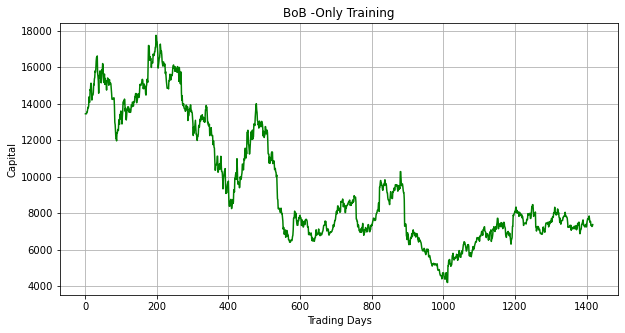

In [12]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('pylab', 'inline')
fig = plt.figure()
ax=X.loc[data_length_start:data_length-2,'cash'].plot(grid="True",figsize=(10,5), title='BoB -Only Training',color="g")
ax.set_xlabel("Trading Days")
ax.set_ylabel("Capital")
plt.savefig("IMAGES/BoB-Train.png")
plt.show()